→ run 1/30
→ run 2/30
→ run 3/30
→ run 4/30
→ run 5/30
→ run 6/30
→ run 7/30
→ run 8/30
→ run 9/30
→ run 10/30
→ run 11/30
→ run 12/30
→ run 13/30
→ run 14/30
→ run 15/30
→ run 16/30
→ run 17/30
→ run 18/30
→ run 19/30
→ run 20/30
→ run 21/30
→ run 22/30
→ run 23/30
→ run 24/30
→ run 25/30
→ run 26/30
→ run 27/30
→ run 28/30
→ run 29/30
→ run 30/30

========= FINAL-GEN RESULTS (30 runs) =========
       Alg           HV mean            HV std            HV med            HV IQR  IGD mean  IGD std  IGD med  IGD IQR  sec/run
0     MODE 70249459480181.89  8890484248038.92 71546217168376.47 11742226547010.22    246.29   179.06   206.08   170.24     1.86
1  NSGA-II 39249953504400.24  6856324816280.16 41069457461006.64 11296055298146.25   1426.62   304.30  1420.95   449.51     0.97
2    SPEA2 37019568254220.61  5538036122453.78 38030953582548.78  8790360498447.15   1433.78   292.94  1420.95   421.64     0.92
3    MOPSO 37201945942116.67 11102463861227.51 35959390264280.85 17440136780460.64  

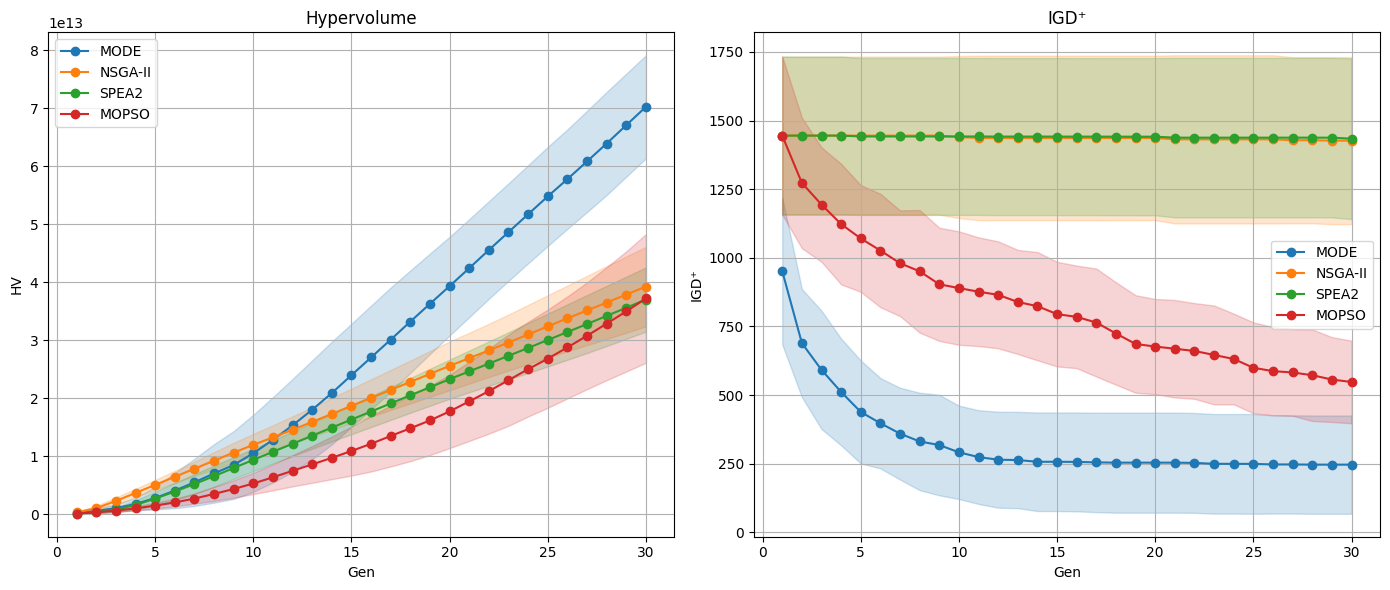

In [ ]:
#!/usr/bin/env python3
# ================================================================
# Tri-objective evacuation comparison
# ================================================================


import time, random, collections, heapq, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from   scipy.stats import mannwhitneyu      #  pip install scipy

# --------------------------- PARAMETERS --------------------------
WALK_SPEED = 1.4
DEFAULT_CAP_CORRIDOR, DEFAULT_CAP_STAIR = 20, 10
DEFAULT_CAP_EXIT,    DEFAULT_CAP_OTHER = 40, 15

POP_SIZE, GENERATIONS, RUNS = 40, 30, 30

# MODE parameters
F, CR = 0.9, 0.8
# NSGA-II parameters
ETA_C, ETA_M, CXPB = 20, 20, 0.9
MUTPB               = 1.0 / POP_SIZE
# SPEA2 parameter
SPEA2_ARCHIVE_SIZE  = POP_SIZE
# MOPSO parameters
W_INERTIA, C1, C2   = 0.5, 2.0, 2.0
# -----------------------------------------------------------------

# ---------------------  BUILDING GEOMETRY  -----------------------
NODES = {
    # Floor 1
    "F1R1":{"floor":1,"type":"Room","occupants":15}, "F1R2":{"floor":1,"type":"Room","occupants":10},
    "F1R3":{"floor":1,"type":"Room","occupants":12}, "F1R4":{"floor":1,"type":"Room","occupants":8},
    "F1R5":{"floor":1,"type":"Room","occupants":22}, "F1R6":{"floor":1,"type":"Room","occupants":20},
    "F1C1":{"floor":1,"type":"Corridor","occupants":0}, "F1C2":{"floor":1,"type":"Corridor","occupants":0},
    "S1F1":{"floor":1,"type":"Stair","occupants":0},   "S2F1":{"floor":1,"type":"Stair","occupants":0},
    "E1":{"floor":1,"type":"Exit","occupants":0},      "E2":{"floor":1,"type":"Exit","occupants":0},
    "E3":{"floor":1,"type":"Exit","occupants":0},
    # Floor 2
    "F2R1":{"floor":2,"type":"Room","occupants":14}, "F2R2":{"floor":2,"type":"Room","occupants":16},
    "F2R3":{"floor":2,"type":"Room","occupants":18}, "F2R4":{"floor":2,"type":"Room","occupants":10},
    "F2R5":{"floor":2,"type":"Room","occupants":12}, "F2R6":{"floor":2,"type":"Room","occupants":25},
    "F2C1":{"floor":2,"type":"Corridor","occupants":0}, "F2C2":{"floor":2,"type":"Corridor","occupants":0},
    "S1F2":{"floor":2,"type":"Stair","occupants":0},  "S2F2":{"floor":2,"type":"Stair","occupants":0},
    # Floor 3
    "F3R1":{"floor":3,"type":"Room","occupants":20}, "F3R2":{"floor":3,"type":"Room","occupants":15},
    "F3R3":{"floor":3,"type":"Room","occupants":12}, "F3R4":{"floor":3,"type":"Room","occupants":18},
    "F3R5":{"floor":3,"type":"Room","occupants":16}, "F3R6":{"floor":3,"type":"Room","occupants":14},
    "F3C1":{"floor":3,"type":"Corridor","occupants":0}, "F3C2":{"floor":3,"type":"Corridor","occupants":0},
    "S1F3":{"floor":3,"type":"Stair","occupants":0},  "S2F3":{"floor":3,"type":"Stair","occupants":0},
    # Floor 4
    "F4R1":{"floor":4,"type":"Room","occupants":12}, "F4R2":{"floor":4,"type":"Room","occupants":8},
    "F4R3":{"floor":4,"type":"Room","occupants":10}, "F4R4":{"floor":4,"type":"Room","occupants":25},
    "F4R5":{"floor":4,"type":"Room","occupants":22}, "F4R6":{"floor":4,"type":"Room","occupants":15},
    "F4C1":{"floor":4,"type":"Corridor","occupants":0}, "F4C2":{"floor":4,"type":"Corridor","occupants":0},
    "S1F4":{"floor":4,"type":"Stair","occupants":0},  "S2F4":{"floor":4,"type":"Stair","occupants":0},
    # Floor 5
    "F5R1":{"floor":5,"type":"Room","occupants":15}, "F5R2":{"floor":5,"type":"Room","occupants":20},
    "F5R3":{"floor":5,"type":"Room","occupants":18}, "F5R4":{"floor":5,"type":"Room","occupants":16},
    "F5R5":{"floor":5,"type":"Room","occupants":10}, "F5R6":{"floor":5,"type":"Room","occupants":12},
    "F5C1":{"floor":5,"type":"Corridor","occupants":0}, "F5C2":{"floor":5,"type":"Corridor","occupants":0},
    "S1F5":{"floor":5,"type":"Stair","occupants":0},  "S2F5":{"floor":5,"type":"Stair","occupants":0},
}

EDGES = [
    # Floor-1
    ("F1R1","F1C1",5,0.20,None),("F1R2","F1C1",5,0.20,None),
    ("F1R3","F1C2",6,0.30,None),("F1R4","F1C2",5,0.20,None),
    ("F1R5","F1C1",8,0.40,None),("F1R6","F1C2",8,0.40,None),
    ("F1C1","F1C2",3,0.20,None),
    ("F1C1","S1F1",4,0.20,None), ("F1C2","S2F1",4,0.20,None),
    ("S1F1","E1",5,0.10,None),   ("S2F1","E2",5,0.10,None),
    ("F1C2","E3",6,0.10,None),
    # Floor-2
    ("F2R1","F2C1",5,0.20,None),("F2R2","F2C1",6,0.30,None),
    ("F2R3","F2C2",6,0.30,None),("F2R4","F2C2",5,0.20,None),
    ("F2R5","F2C1",7,0.40,None),("F2R6","F2C2",8,0.50,None),
    ("F2C1","F2C2",3,0.20,None),
    ("F2C1","S1F2",4,0.20,None),("F2C2","S2F2",4,0.20,None),
    # Floor-3
    ("F3R1","F3C1",5,0.20,None),("F3R2","F3C1",5,0.30,None),
    ("F3R3","F3C2",6,0.30,None),("F3R4","F3C2",5,0.20,None),
    ("F3R5","F3C1",7,0.40,None),("F3R6","F3C2",8,0.50,None),
    ("F3C1","F3C2",3,0.20,None),
    ("F3C1","S1F3",4,0.20,None),("F3C2","S2F3",4,0.20,None),
    # Floor-4
    ("F4R1","F4C1",5,0.30,None),("F4R2","F4C1",6,0.40,None),
    ("F4R3","F4C2",6,0.40,None),("F4R4","F4C2",5,0.30,None),
    ("F4R5","F4C1",8,0.50,None),("F4R6","F4C2",7,0.50,None),
    ("F4C1","F4C2",3,0.30,None),
    ("F4C1","S1F4",4,0.30,None),("F4C2","S2F4",4,0.30,None),
    # Floor-5
    ("F5R1","F5C1",5,0.30,None),("F5R2","F5C1",6,0.40,None),
    ("F5R3","F5C2",6,0.50,None),("F5R4","F5C2",5,0.40,None),
    ("F5R5","F5C1",8,0.60,None),("F5R6","F5C2",7,0.50,None),
    ("F5C1","F5C2",3,0.30,None),
    ("F5C1","S1F5",4,0.30,None),("F5C2","S2F5",4,0.30,None),
    # Inter-floor stairs
    ("S1F1","S1F2",8,0.20,None),("S1F2","S1F3",8,0.20,None),
    ("S1F3","S1F4",8,0.30,None),("S1F4","S1F5",8,0.30,None),
    ("S2F1","S2F2",8,0.20,None),("S2F2","S2F3",8,0.20,None),
    ("S2F3","S2F4",8,0.30,None),("S2F4","S2F5",8,0.30,None),
]
# -----------------------------------------------------------------
def _cap(node):
    t = NODES[node]['type']
    return {'Room':DEFAULT_CAP_OTHER, 'Corridor':DEFAULT_CAP_CORRIDOR,
            'Stair':DEFAULT_CAP_STAIR, 'Exit':DEFAULT_CAP_EXIT}[t]

graph, EDGE_DATA = collections.defaultdict(list), {}
for u,v,d,r,cap in EDGES:
    c2 = cap if cap is not None else min(_cap(u),_cap(v))
    EDGE_DATA[(u,v)] = EDGE_DATA[(v,u)] = {'dist':d,'risk':r,'cap':c2}
    graph[u].append(v); graph[v].append(u)

ROOMS  = [n for n in NODES if NODES[n]['type']=='Room']
EXITS  = [n for n in NODES if NODES[n]['type']=='Exit']
NUM_ROOMS, NUM_EXITS = len(ROOMS), len(EXITS)

# ------------------  PRE-COMPUTE PATHS  --------------------------
PATH_EDGES={}
def dijkstra(src):
    dist, prev = {src:0.0}, {src:None}
    pq=[(0.0,src)]
    while pq:
        D,u = heapq.heappop(pq)
        if dist[u]!=D: continue
        for w in graph[u]:
            nd=D+EDGE_DATA[(u,w)]['dist']
            if w not in dist or nd<dist[w]:
                dist[w],prev[w]=nd,u; heapq.heappush(pq,(nd,w))
    return dist,prev

for rm in ROOMS:
    d,pr = dijkstra(rm)
    for ex in EXITS:
        if ex in d:
            path=[]; cur=ex
            while cur: path.append(cur); cur=pr[cur]
            path=path[::-1]
            PATH_EDGES[(rm,ex)] = list(zip(path[:-1],path[1:]))
        else: PATH_EDGES[(rm,ex)]=[]

# ------------------ COST FUNCTION -------------------------------
def chrom_cost(ch):
    load=collections.Counter()
    for g,rm in zip(ch,ROOMS):           # first pass → edge loads
        p=NODES[rm]['occupants']
        for e in PATH_EDGES[(rm,EXITS[g])]: load[e]+=p
    T=C=H=0.0
    for g,rm in zip(ch,ROOMS):           # second pass → metrics
        p=NODES[rm]['occupants']
        for e in PATH_EDGES[(rm,EXITS[g])]:
            d,r,c = (EDGE_DATA[e][k] for k in ('dist','risk','cap'))
            T += d/WALK_SPEED * p
            C += load[e]/c * p
            H += (r+d) * p
    return (T,C,H)

# ------------------ BASIC UTILITIES -----------------------------
def random_chrom(): return [random.randrange(NUM_EXITS) for _ in ROOMS]
def dominates(a,b): return all(x<=y for x,y in zip(a,b)) and any(x<y for x,y in zip(a,b))

def non_dominated_sort(pop):
    S=[set() for _ in pop]; n=[0]*len(pop); fronts=[[]]
    for i,p in enumerate(pop):
        for j,q in enumerate(pop):
            if dominates(p[1],q[1]): S[i].add(j)
            elif dominates(q[1],p[1]): n[i]+=1
        if n[i]==0: fronts[0].append(i)
    k=0
    while fronts[k]:
        nxt=[]
        for i in fronts[k]:
            for j in S[i]:
                n[j]-=1
                if n[j]==0: nxt.append(j)
        k+=1; fronts.append(nxt)
    fronts.pop(); return fronts

def compute_crowding_distance(front):
    if not front: return []
    size=len(front); m=len(front[0][1]); dist=[0]*size
    for obj in range(m):
        sorted_f=sorted(front,key=lambda x:x[1][obj])
        dist[0]=dist[-1]=float('inf')
        lo,hi=sorted_f[0][1][obj],sorted_f[-1][1][obj]
        if hi>lo:
            for i in range(1,size-1):
                prev,nxt=sorted_f[i-1][1][obj],sorted_f[i+1][1][obj]
                dist[i]+=(nxt-prev)/(hi-lo)
    return dist

def hypervolume(front,ref):
    pts=[p for p in front if all(p[i]<ref[i] for i in range(3))]
    return sum((ref[0]-t)*(ref[1]-c)*(ref[2]-h) for t,c,h in pts)

def igd_plus(front,refF):
    if not front: return math.inf
    return sum(min(math.sqrt(sum(max(0,s-r)**2 for s,r in zip(sol,ref)))
                   for sol in front) for ref in refF)/len(refF)

# ----------------------  COMMON SEED  ---------------------------
def greedy_chrom():
    out=[]
    for rm in ROOMS:
        best=min(range(NUM_EXITS),
                 key=lambda e: sum(EDGE_DATA[e2]['dist']+EDGE_DATA[e2]['risk']
                                   for e2 in PATH_EDGES[(rm,EXITS[e])]))
        out.append(best)
    return out

SEED_CHROM = greedy_chrom()
# ----------------------------------------------------------------
# >>>>>>>>>>>>>>>>>>>>>>>>>  SOLVERS  <<<<<<<<<<<<<<<<<<<<<<<<<<<<
def nfpa_ok(ch):
    for g, rm in zip(ch, ROOMS):
        for u, v in PATH_EDGES[(rm, EXITS[g])]:
            if EDGE_DATA[(u, v)]['cap'] < 2.0:   # < 2 m ⇒ reject
                return False
    return True


# ────────────────────────────────────────────────────────────────
def solver_mode(seed):
    """Multi-Objective Differential Evolution (MODE) solver
       + NFPA bottleneck filter on the *final* front."""
    random.seed(seed)

    # ---------- S0  initialise -----------------------------------
    pop = [
        [SEED_CHROM,      chrom_cost(SEED_CHROM)],   # common seed
        [greedy_chrom(),  chrom_cost(SEED_CHROM)]    # same again (idempotent)
    ]
    while len(pop) < POP_SIZE:                       # fill the rest at random
        r = random_chrom()
        pop.append([r, chrom_cost(r)])

    history = []

    # ---------- generations  ------------------------------------
    for _ in range(GENERATIONS):
        best = min(pop, key=lambda x: x[1])[0]       # champion (for DE/best/1)

        # S1  DE variation ----------------------------------------------------
        offs = []
        for i in range(POP_SIZE):
            a = random.randrange(POP_SIZE)
            mutant = [
                max(0, min(NUM_EXITS - 1,
                           int(round(pop[a][0][j] + F * (best[j] - pop[a][0][j])))))
                for j in range(NUM_ROOMS)
            ]
            child = [
                mutant[j] if random.random() < CR else pop[i][0][j]
                for j in range(NUM_ROOMS)
            ]
            offs.append([child, chrom_cost(child)])

        # S2  greedy replacement + environmental selection -------------------
        combined = pop + offs
        fronts   = non_dominated_sort(combined)
        all_objs = [ind[1] for ind in combined]
        hv_ref   = [max(o[i] for o in all_objs) * 1.1 for i in range(3)]

        newpop = []
        for fr in fronts:
            if len(newpop) + len(fr) <= POP_SIZE:
                newpop += [combined[i] for i in fr]
            else:                                   # HV contribution truncation
                cand   = [combined[i] for i in fr]
                base   = hypervolume([x[1] for x in newpop + cand], hv_ref)
                contrib = [
                    base - hypervolume([x[1] for x in newpop + cand if x is not c],
                                       hv_ref)
                    for c in cand
                ]
                K = POP_SIZE - len(newpop)
                newpop += [c for c, _ in sorted(zip(cand, contrib),
                                                key=lambda x: -x[1])[:K]]
                break

        # S3  tiny 3-swap hill-climb ----------------------------------------
        for indiv in newpop:
            for _ in range(3):
                i, j = random.sample(range(NUM_ROOMS), 2)
                trial = indiv[0][:]
                trial[i], trial[j] = trial[j], trial[i]
                c2 = chrom_cost(trial)
                if dominates(c2, indiv[1]):
                    indiv[0], indiv[1] = trial, c2

        pop = newpop
        history.append((pop, non_dominated_sort(pop)))

    # ----------  NFPA 2-m bottleneck filter -----------------------------
    final_pop = [ind for ind in pop if nfpa_ok(ind[0])]
    if not final_pop:
        final_pop = pop

    return history, [ind[1] for ind in final_pop]
# ────────────────────────────────────────────────────────────────


def sbx_crossover(p1,p2):
    c1,p2=p1[:],p2[:]
    for i in range(NUM_ROOMS):
        if random.random()<=CXPB:
            u=random.random()
            beta=(2*u)**(1/(ETA_C+1)) if u<=0.5 else (1/(2*(1-u)))**(1/(ETA_C+1))
            x1,x2=p1[i],p2[i]
            c1[i]=int(round(max(0,min(NUM_EXITS-1,0.5*((1+beta)*x1+(1-beta)*x2)))))
    return c1

def polynomial_mutation(ch):
    c=ch[:]
    for i in range(NUM_ROOMS):
        if random.random()<=MUTPB:
            x=c[i]; d1=x/(NUM_EXITS-1); d2=(NUM_EXITS-1-x)/(NUM_EXITS-1)
            u=random.random(); mu=1.0/(ETA_M+1)
            delta=((2*u+(1-2*u)*(1-d1)**(ETA_M+1))**mu-1) if u<0.5 else \
                  (1-(2*(1-u)+2*(u-0.5)*(1-d2)**(ETA_M+1))**mu)
            c[i]=int(round(max(0,min(NUM_EXITS-1,x+delta*(NUM_EXITS-1)))))
    return c

def solver_nsga2(seed):
    random.seed(seed)
    pop=[[SEED_CHROM,chrom_cost(SEED_CHROM)]]
    while len(pop)<POP_SIZE:
        r=random_chrom(); pop.append([r,chrom_cost(r)])
    history=[]
    for _ in range(GENERATIONS):
        offspring=[]
        while len(offspring)<POP_SIZE:
            i,j=random.sample(range(POP_SIZE),2)
            winner=pop[i] if non_dominated_sort([pop[i],pop[j]])[0][0]==0 else pop[j]
            k,_=random.sample(range(POP_SIZE),2)
            child=(sbx_crossover(winner[0],pop[k][0])
                   if random.random()<CXPB else winner[0][:])
            child=polynomial_mutation(child)
            offspring.append([child,chrom_cost(child)])
        combined=pop+offspring
        fronts=non_dominated_sort(combined); newpop=[]
        for fr in fronts:
            if len(newpop)+len(fr)<=POP_SIZE:
                newpop+=[combined[i] for i in fr]
            else:
                front_inds=[combined[i] for i in fr]
                cds=compute_crowding_distance(front_inds)
                newpop+=[c for c,_ in sorted(zip(front_inds,cds),
                                             key=lambda x:-x[1])[:POP_SIZE-len(newpop)]]
                break
        pop=newpop; history.append((pop,non_dominated_sort(pop)))
    return history,[ind[1] for ind in pop]

def solver_spea2(seed):
    random.seed(seed)
    pop=[[SEED_CHROM,chrom_cost(SEED_CHROM)]]
    while len(pop)<POP_SIZE:
        r=random_chrom(); pop.append([r,chrom_cost(r)])
    archive=[]; history=[]
    for _ in range(GENERATIONS):
        union=pop+archive
        strength=[sum(dominates(u1[1],u2[1]) for u2 in union) for u1 in union]
        raw=[sum(strength[j] for j,u2 in enumerate(union) if dominates(u2[1],u1[1]))
             for u1 in union]
        k=int(math.sqrt(len(union)))
        density=[1/(sorted(math.dist(u1[1],u2[1]) for j,u2 in enumerate(union) if j!=i)[k]+2)
                 for i,u1 in enumerate(union)]
        fitness=[r+d for r,d in zip(raw,density)]
        archive=[union[i] for i in sorted(range(len(union)),key=lambda i:fitness[i])
                 [:SPEA2_ARCHIVE_SIZE]]
        pop=[]
        while len(pop)<POP_SIZE:
            a,b=random.sample(range(len(archive)),2)
            child=(sbx_crossover(archive[a][0],archive[b][0])
                   if random.random()<CXPB else archive[a][0][:])
            child=polynomial_mutation(child)
            pop.append([child,chrom_cost(child)])
        history.append((archive,non_dominated_sort(archive)))
    return history,[ind[1] for ind in archive]

def solver_mopso(seed):
    random.seed(seed)
    swarm=[[SEED_CHROM,chrom_cost(SEED_CHROM)]]
    while len(swarm)<POP_SIZE:
        r=random_chrom(); swarm.append([r,chrom_cost(r)])
    pbest=[s[0][:] for s in swarm]; pbest_cost=[s[1] for s in swarm]
    archive=[]; history=[]; vel=[[0]*NUM_ROOMS for _ in range(POP_SIZE)]
    for _ in range(GENERATIONS):
        for i,(pos,cst) in enumerate(swarm):
            if dominates(cst,pbest_cost[i]): pbest[i],pbest_cost[i]=pos[:],cst
        for i in range(POP_SIZE):
            cand=(pbest[i],pbest_cost[i])
            if not any(dominates(a[1],cand[1]) for a in archive): archive.append(cand)
        archive=[a for a in archive if not any(dominates(b[1],a[1])
                                               for b in archive if b!=a)]
        history.append((archive,non_dominated_sort([[None,c] for _,c in archive])))
        gbest=random.choice(archive)[0]; new_sw=[]
        for i,(pos,_) in enumerate(swarm):
            v=vel[i]
            for j in range(NUM_ROOMS):
                rp,rg=random.random(),random.random()
                v[j]=W_INERTIA*v[j]+C1*rp*(pbest[i][j]-pos[j])+C2*rg*(gbest[j]-pos[j])
                pos[j]=pbest[i][j] if random.random()<1/(1+math.exp(-v[j])) else gbest[j]
            new_sw.append([pos[:],chrom_cost(pos)]); vel[i]=v
        swarm=new_sw
    return history,[c for _,c in archive]


# -----------------------------------------------------------------
#        REFERENCE FRONT / POINT  (unchanged logic)
# -----------------------------------------------------------------
def build_references(all_sols_lists,histories):
    union=[]
    for hlist in histories:
        for hist in hlist:
            pop_fin,front_fin=hist[-1]
            union+= [pop_fin[idx][1] for idx in front_fin[0]]
    static=[p for p in union if not any(dominates(q,p) for q in union if q!=p)]
    all_pts=[pt for alg in all_sols_lists for run in alg for pt in run]
    ref=[max(pt[i] for pt in all_pts)*1.1 for i in range(3)]
    return static,ref

# ---------------  AGGREGATE CURVES (unchanged) -------------------
def aggregate_metrics(histories,all_sols,static_ref,ref_pt):
    R,G=len(histories),len(histories[0])
    hv=np.zeros((R,G)); igd=np.zeros((R,G))
    for r in range(R):
        archive=[]
        for g,(pop,fronts) in enumerate(histories[r]):
            f0=fronts[0] if fronts and fronts[0] else []
            front_objs=[pop[i][1] for i in f0]
            for sol in front_objs:
                if not any(dominates(prev,sol) for prev in archive):
                    archive.append(sol)
            hv[r,g]=hypervolume(archive,ref_pt)
            igd[r,g]=igd_plus(archive,static_ref)
    return hv.mean(0),hv.std(0),igd.mean(0),igd.std(0),hv,igd

# --------------------  MAIN BENCHMARK LOOP  ----------------------
def run_all():
    global SAMPLE
    if len(SAMPLE)<5000: SAMPLE=[chrom_cost(random_chrom()) for _ in range(5000)]
    h_m,s_m,h_n,s_n,h_s,s_s,h_p,s_p=[],[],[],[],[],[],[],[]
    for seed in range(RUNS):
        print(f"→ run {seed+1}/{RUNS}")
        hm,am=solver_mode(seed);    h_m.append(hm); s_m.append(am)
        hn,an=solver_nsga2(seed);   h_n.append(hn); s_n.append(an)
        hs,as_=solver_spea2(seed);  h_s.append(hs); s_s.append(as_)
        hp,ap=solver_mopso(seed);   h_p.append(hp); s_p.append(ap)
    return (h_m,s_m),(h_n,s_n),(h_s,s_s),(h_p,s_p)

# -------------   EXECUTE ALL SOLVERS ONCE   ---------------------
SAMPLE=[chrom_cost(random_chrom()) for _ in range(5000)]
((h_m,s_m),(h_n,s_n),(h_s,s_s),(h_p,s_p)) = run_all()



static_ref, ref_pt = build_references([s_m,s_n,s_s,s_p],[h_m,h_n,h_s,h_p])

mv_m,sv_m,mi_m,si_m,hvmatM,igdmatM = aggregate_metrics(h_m,s_m,static_ref,ref_pt)
mv_n,sv_n,mi_n,si_n,hvmatN,igdmatN = aggregate_metrics(h_n,s_n,static_ref,ref_pt)
mv_s,sv_s,mi_s,si_s,hvmatS,igdmatS = aggregate_metrics(h_s,s_s,static_ref,ref_pt)
mv_p,sv_p,mi_p,si_p,hvmatP,igdmatP = aggregate_metrics(h_p,s_p,static_ref,ref_pt)

# ---------- grab per-run final HV & IGD⁺ samples ----------
hvM,hvN,hvS,hvP = hvmatM[:,-1],hvmatN[:,-1],hvmatS[:,-1],hvmatP[:,-1]
igM,igN,igS,igP = igdmatM[:,-1],igdmatN[:,-1],igdmatS[:,-1],igdmatP[:,-1]

# ---------- runtime / run (seconds) ----------------------
def avg_runtime(fn):
    t0=time.time()
    for seed in range(RUNS): fn(seed)
    return (time.time()-t0)/RUNS
runtime={'MODE':avg_runtime(solver_mode),
         'NSGA-II':avg_runtime(solver_nsga2),
         'SPEA2':avg_runtime(solver_spea2),
         'MOPSO':avg_runtime(solver_mopso)}

# ---------- Mann–Whitney U significance ------------------
def U(a,b): return mannwhitneyu(a,b,alternative='greater').pvalue
p_hv={'MODE>NSGA':U(hvM,hvN),'MODE>SPEA':U(hvM,hvS),'MODE>MOPSO':U(hvM,hvP)}


# ---------- assemble final summary table -----------------
def stats(v):                 # mean, std, median, IQR
    return np.mean(v),np.std(v),np.median(v),np.percentile(v,75)-np.percentile(v,25)
tbl=pd.DataFrame({
    'Alg':['MODE','NSGA-II','SPEA2','MOPSO'],
    'HV mean':[stats(hvM)[0],stats(hvN)[0],stats(hvS)[0],stats(hvP)[0]],
    'HV std' :[stats(hvM)[1],stats(hvN)[1],stats(hvS)[1],stats(hvP)[1]],
    'HV med' :[stats(hvM)[2],stats(hvN)[2],stats(hvS)[2],stats(hvP)[2]],
    'HV IQR' :[stats(hvM)[3],stats(hvN)[3],stats(hvS)[3],stats(hvP)[3]],
    'IGD mean':[stats(igM)[0],stats(igN)[0],stats(igS)[0],stats(igP)[0]],
    'IGD std' :[stats(igM)[1],stats(igN)[1],stats(igS)[1],stats(igP)[1]],
    'IGD med' :[stats(igM)[2],stats(igN)[2],stats(igS)[2],stats(igP)[2]],
    'IGD IQR' :[stats(igM)[3],stats(igN)[3],stats(igS)[3],stats(igP)[3]],
    'sec/run':[runtime['MODE'],runtime['NSGA-II'],runtime['SPEA2'],runtime['MOPSO']]
})

print("\n========= FINAL-GEN RESULTS (30 runs) =========")
print(tbl.to_string(float_format="%.2f"))

print("\nMann–Whitney U ")
for k,v in p_hv.items(): print(f"  HV  {k}: p = {v:.3e}")

print("\nLaTeX table:\n")
print(tbl.to_latex(index=False, float_format="%.2f"))

# ---------- curves (same plotting code, unchanged) -------
gens=np.arange(1,GENERATIONS+1)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for m,s,l,c in [(mv_m,sv_m,'MODE','C0'),(mv_n,sv_n,'NSGA-II','C1'),
                (mv_s,sv_s,'SPEA2','C2'),(mv_p,sv_p,'MOPSO','C3')]:
    plt.plot(gens,m,'-o',label=l,color=c)
    plt.fill_between(gens,m-s,m+s,alpha=0.2,color=c)
plt.title("Hypervolume"); plt.xlabel("Gen"); plt.ylabel("HV"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
for m,s,l,c in [(mi_m,si_m,'MODE','C0'),(mi_n,si_n,'NSGA-II','C1'),
                (mi_s,si_s,'SPEA2','C2'),(mi_p,si_p,'MOPSO','C3')]:
    plt.plot(gens,m,'-o',label=l,color=c)
    plt.fill_between(gens,m-s,m+s,alpha=0.2,color=c)
plt.title("IGD⁺"); plt.xlabel("Gen"); plt.ylabel("IGD⁺"); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()
